# Build A Rocket And Launch It

Procedurally build and simulate a flight. This is my attempt to use the [open aerospace rocket documentation tool](https://open-aerospace.github.io/openrocketdoc/) to describe a rocket and generate JSBSim configuration to simulate its flight.

View the raw jupyter notebook: [rocket.ipynb](https://github.com/natronics/JSBSim-Manager/blob/master/rocket.ipynb)

You can run it yourself by cloning this repo and install requirements:

    $ pip install -r requirements.txt

Then run jupyter to edit/run the document in your browser:

    $ jupyter notebook

The idea is that you can make up some numbers ("what if I built a rocket with _this_ much thrust?") and this script will parametrically design an entire rocket. Then using openrocketdoc, generate a valid JSBSim case and run JSBSim for you, generating flight simulation output.

Just put in numbers for the engine design and then run the notebook!


## Step 1. Design The Engine

Pick an engine design. Well define it based on a desired Isp, thrust, and burn time.

In [12]:
import locale
from openrocketdoc import document
from openrocketdoc import writers
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')

# Subclass the Engine class from openrocketdoc
class CustomEngine(document.Engine):
    def __init__(self, name):
        super().__init__(name)
        # You can initialize additional properties here if needed
        self.components = []  # Ensure components attribute always exists

    # Example of overriding a method
    # If the Engine class has specific methods you want to change, you can redefine them here
    # For instance, if you want to customize how the thrust is printed:
    # def print_thrust(self):
    #     print(" %14s |  %s | %s" % ("Thrust", locale.format_string("%8.1f", self.thrust_avg, grouping=True), "N"))

###############################################################
#  CHANGE THESE NUMBERS!! IT'S FUN.
thrust     = 1555.0  # N
burn_time  =   10.0  # s
isp        =  214.0  # s
################################################################

# Create an engine document
# engine = document.Engine('Python Motor')
engine = CustomEngine('Python Motor')


# Set our design
engine.Isp = isp
engine.thrust_avg = thrust
engine.t_burn = burn_time

# Print setup
print("Engine Design parameters:\n")
print("      Input     |   Number  | Units ")
print(" -------------- | --------: | :---- ")

print(" %14s |  %8.1f | %s" % ("Isp", engine.Isp, "s"))
print(" %14s |  %s | %s" % ("Thrust", locale.format_string("%8.1f", engine.thrust_avg, grouping=True), "N"))
print(" %14s |  %8.1f | %s" % ("Burn Time", engine.t_burn, "s"))


Engine Design parameters:

      Input     |   Number  | Units 
 -------------- | --------: | :---- 
            Isp |     214.0 | s
         Thrust |   1,555.0 | N
      Burn Time |      10.0 | s


All we need to do is create an openrocketdoc Engine with those basic numbers:

```python
from openrocketdoc import document

engine = document.Engine('My Rocket Motor')
engine.Isp = 214.0
engine.thrust_avg = 1555.0
engine.t_burn = 10.0
```

Everything else can be computed from that engine class:

In [13]:
# The Open Rocket Document can compute useful values based on what we defined above.
print("\nOur computed engine will need %0.1f kg of propellent." % engine.m_prop, )
print("It has a total impulse of %s Ns. That would make it a '%s'(%0.0f%%) class motor." % (
        locale.format_string("%d", engine.I_total, grouping=True),
        engine.nar_code,
        engine.nar_percent
     ))

jsbsim_engine_file = writers.JSBSimEngine.dump(engine)
print("\nGenerated JSBSim engine document:\n\n```xml")
print(jsbsim_engine_file)
print("```")


Our computed engine will need 7.4 kg of propellent.
It has a total impulse of 15,550 Ns. That would make it a 'N'(52%) class motor.

Generated JSBSim engine document:

```xml
<?xml version="1.0" ?>
<rocket_engine name="Python Motor">
  <isp>214.0</isp>
  <builduptime>0.1</builduptime>
  <thrust_table name="propulsion/thrust_prop_remain" type="internal">
    <tableData>
      0.000 349.578
      5.445 349.578
      10.890 349.578
    </tableData>
  </thrust_table>
</rocket_engine>

```


## Step 2. Build The Rocket

Now we know how much propellent, guess the density and come up with some parametric rocket design. If we compute some numbers based on a guess of the density of our propellent, we can build up a full rocket desgin from our `engine`. The only hardcoded magic is a prefered lenght-to-diameter ratio.

In [14]:
prop_density = 1750      # kg/m3  Roughtly HTPB composite solid density[1]
LD           =   10      # Length to width ratio
Nose_LD      =    5

# [1] http://www.lr.tudelft.nl/en/organisation/departments/space-engineering/space-systems-engineering/expertise-areas/space-propulsion/design-of-elements/rocket-propellants/solids/

print("Rocket Design parameters:\n")
print("          Input         |   Number  | Units ")
print(" ---------------------- | --------: | :---- ")

print(" %22s |  %s | %s" % ("Propellent Density", locale.format_string("%8.1f", engine.thrust_avg, grouping=True), "kg/m3"))
print(" %22s |  %8.1f | " % ("Motor L/D ratio", 10))
print(" %22s |  %8.1f | " % ("Nosecone L/D ratio", 5))


Rocket Design parameters:

          Input         |   Number  | Units 
 ---------------------- | --------: | :---- 
     Propellent Density |   1,555.0 | kg/m3
        Motor L/D ratio |      10.0 | 
     Nosecone L/D ratio |       5.0 | 


Computed rocket length: 2.8 meters, diameter: 162.77 mm

Generated diagram of the rocket, with a nosecone, fixed length dummy payload section, and motor:


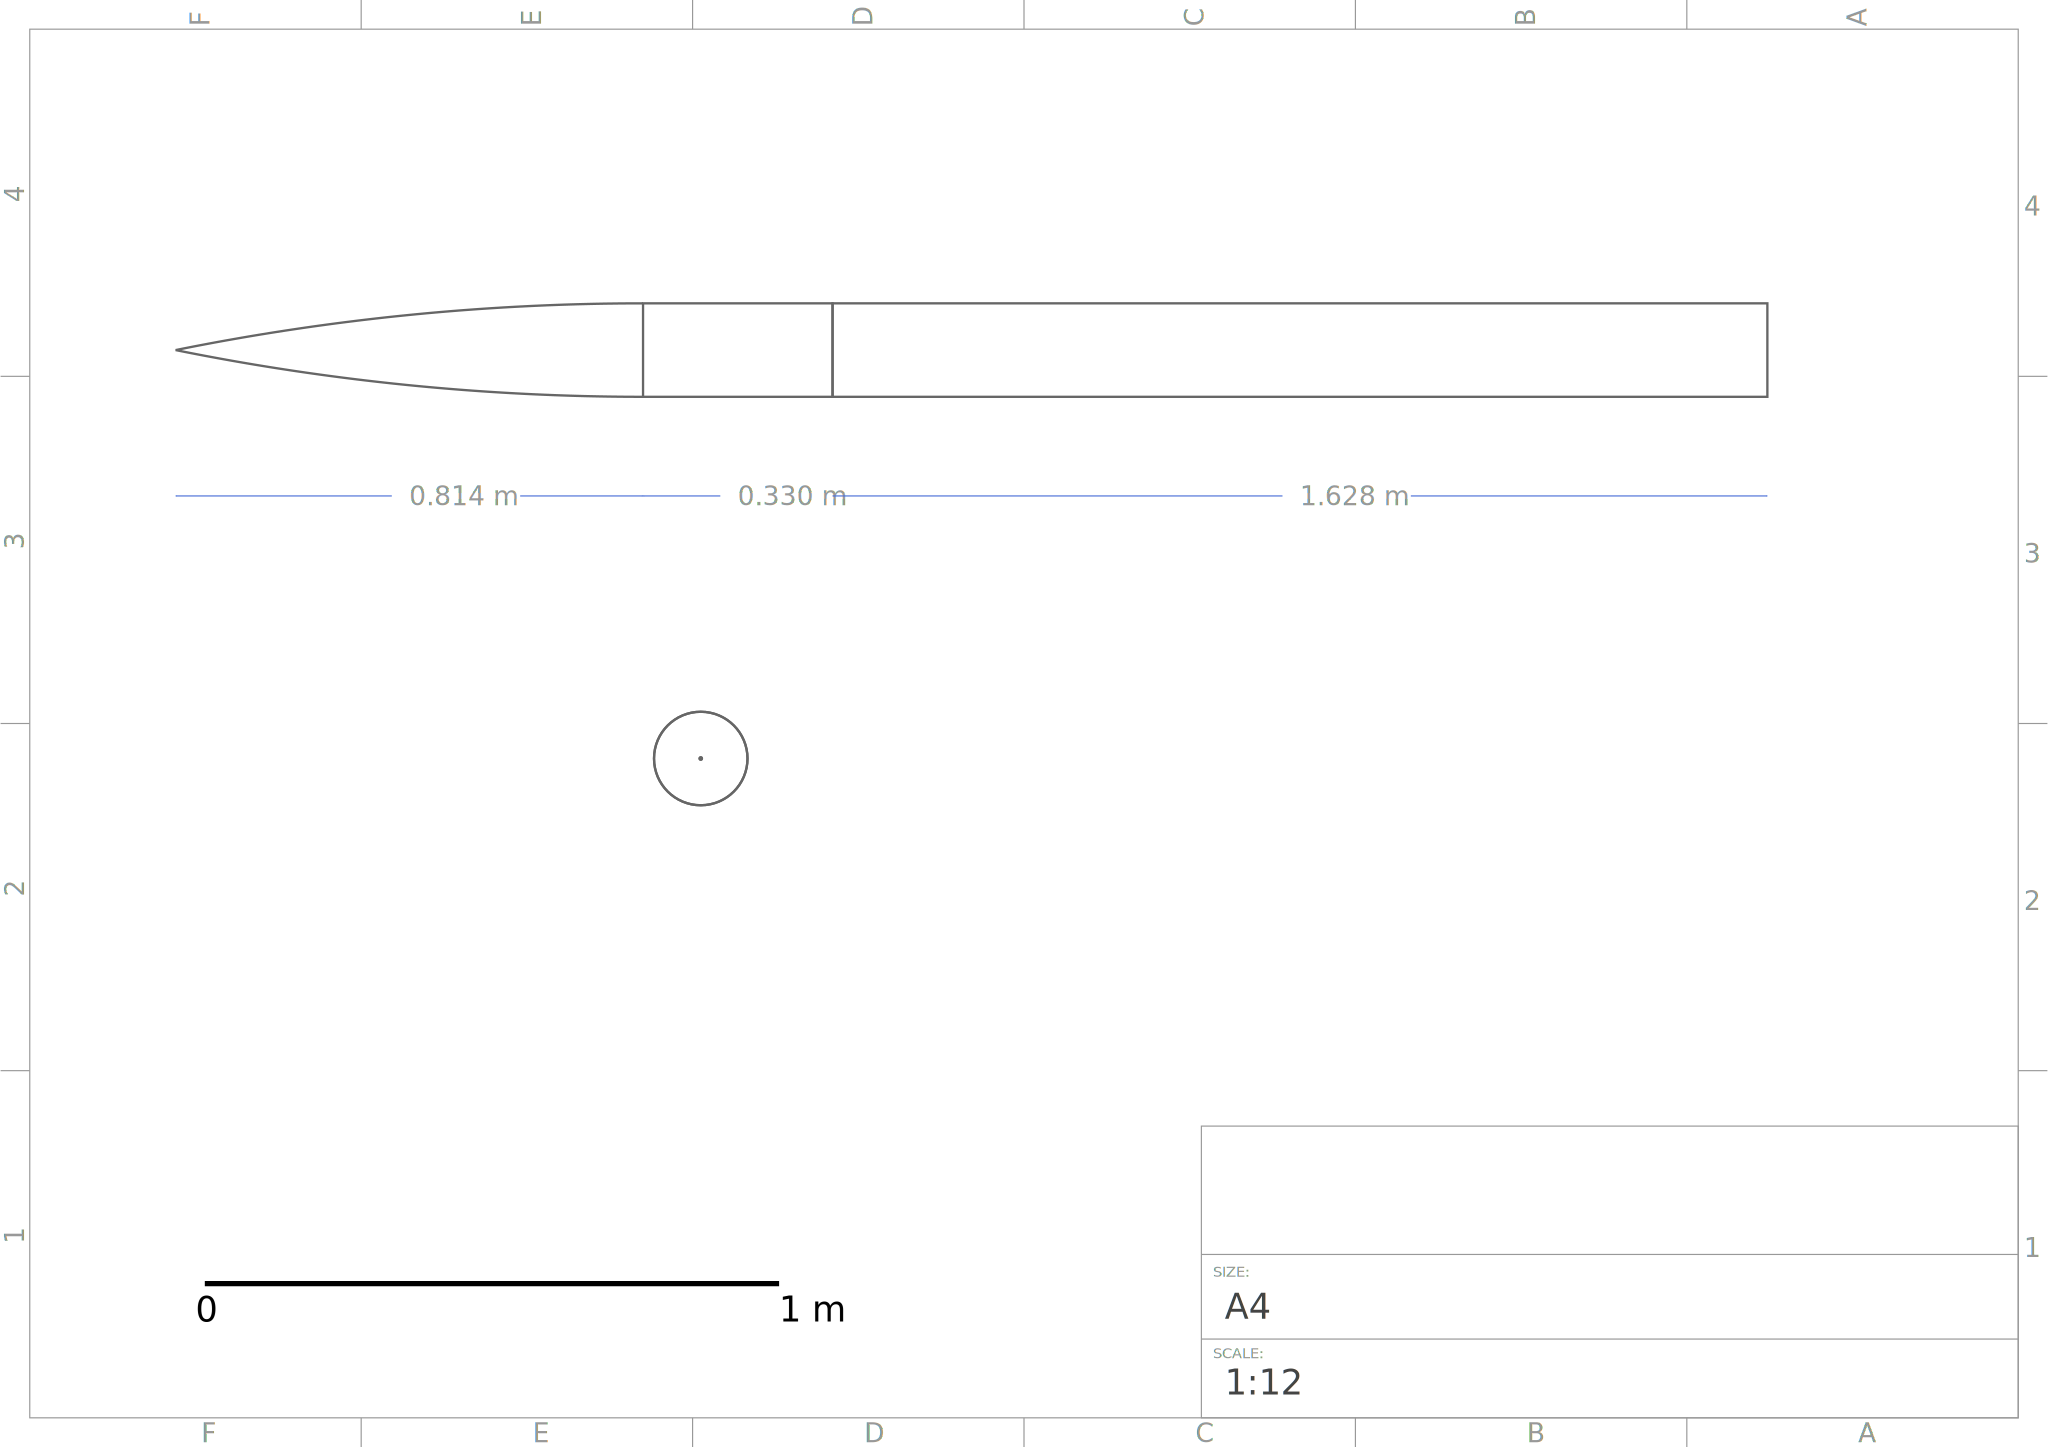

In [16]:
from math import pi

# volume of propellent needed
prop_volume = engine.m_prop/prop_density

# Solve for the radius/length of the fuel grain (assume solid, end burning)
engine.diameter = 2*(prop_volume/ (2*LD*pi))**(1/3.0)
engine.length = engine.diameter * LD

# Add a nose
nose = document.Nosecone(
    document.Noseshape.TANGENT_OGIVE,  # Shape
    1.0, # shape_parameter
    1.5, # mass
    engine.diameter * Nose_LD,
    diameter=engine.diameter,
    material_name="Aluminium"
)

# Payload section
payload = document.Bodytube(
    "Payload",  # Name
    2.5,        # mass
    0.33,       # length
    diameter=engine.diameter,
    material_name="Aluminium"
)

# Body section the size of the engine
body = document.Bodytube(
    "Body",  # Name
    1.5,     # mass
    engine.length,
    diameter=engine.diameter,
    material_name="Aluminium"
)

# body.components = [engine]

# Rocket:
rocket = document.Rocket("Rocket")
rocket.aero_properties['CD'] = [0.6]
stage0 = document.Stage("Sustainer")
stage0.components = [nose, payload, body]
rocket.stages = [stage0]

# Print:
print("Computed rocket length: %0.1f meters, diameter: %0.2f mm\n" % ((nose.length + payload.length + body.length), (engine.diameter*1000.0)))
print("Generated diagram of the rocket, with a nosecone, fixed length dummy payload section, and motor:")

from IPython.display import SVG, display
# display(SVG(writers.SVG.dump(rocket))) # commented out to be replaced with a try/catch block

try:
    display(SVG(writers.SVG.dump(rocket)))
except AttributeError as e:
    print("An error occurred: ", e)
    print("The Engine does not have any components.")




In [17]:
jsbsim_aircraft_file = writers.JSBSimAircraft.dump(rocket)

print("Generated JSBSim 'Aircraft' document:\n\n```xml")
print(jsbsim_aircraft_file)
print("```")

Generated JSBSim 'Aircraft' document:

```xml
<?xml version="1.0" ?>
<fdm_config xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" name="Rocket" version="2.0" xsi:noNamespaceSchemaLocation="http://jsbsim.sourceforge.net/JSBSim.xsd" release="ALPHA">
  <fileheader/>
  <!--

  Primary Metrics (Ovearall size of vehicle)

  -->
  <metrics>
    <wingarea unit="M2">0.0208</wingarea>
    <wingspan unit="M">0.1628</wingspan>
    <chord unit="M">0.0</chord>
    <htailarea unit="M2">0.0</htailarea>
    <htailarm unit="M">0.0</htailarm>
    <vtailarea unit="M2">0.0</vtailarea>
    <vtailarm unit="M">0.0</vtailarm>
    <location name="AERORP" unit="M">
      <x>2.7716</x>
      <y>0.0</y>
      <z>0.0</z>
    </location>
  </metrics>
  <!--

  Mass Elements: describe dry mass of vehicle

  -->
  <mass_balance>
    <pointmass name="Payload">
      <form shape="tube">
        <radius unit="M">0.0814</radius>
        <length unit="M">0.3300</length>
      </form>
      <weight unit="KG">2.5000</we

## Build JSBSim Case

JSBSim needs several files in directories with a particular file structure. We simply write the files above to the filesystem appropriate places. A generic `run.xml` and `init.xml` files are already here. They're almost completely independent from the rocket definitions, the only thing "hard coded" is the name of the rocket (which has to match the filename).

In [18]:
import os

aircraft_path = os.path.join("aircraft", rocket.name_slug)
engine_path = "engine"

if not os.path.exists(aircraft_path):
    os.makedirs(aircraft_path)
if not os.path.exists(engine_path):
    os.makedirs(engine_path)
    
aircraft_filename = rocket.name_slug + '.xml'
with open(os.path.join(aircraft_path, aircraft_filename), 'w') as outfile:
    outfile.write(jsbsim_aircraft_file)

engine_filename = engine.name_slug + '.xml'
with open(os.path.join(engine_path, engine_filename), 'w') as outfile:
    outfile.write(jsbsim_engine_file)

nozzle_filename = engine.name_slug + '_nozzle.xml'
with open(os.path.join(engine_path, nozzle_filename), 'w') as outfile:
    outfile.write("""<?xml version="1.0"?>
<nozzle name="Nozzle">
  <area unit="M2"> 0.001 </area>
</nozzle>
""")

## Run JSBSim

Now we can simulate the flight by invoking JSBSim (assuming you have it installed and in your path). It's as easy as this:

```python
import subprocess
# Run JSBSim using Popen
p = subprocess.Popen(["JSBSim", "--logdirectivefile=output_file.xml", "--script=run.xml"])
```

In [19]:
import subprocess
import time
# Run JSBSim using Popen
p = subprocess.Popen(["JSBSim", "--logdirectivefile=output_file.xml", "--script=run.xml"])
time.sleep(10) # let it run

## Analyze The Simulation Results

Now we should have a datafile from the simulation!

In [21]:
import csv
# Read data from JSBSim

FPS2M = 0.3048
LBF2N = 4.44822
LBS2KG = 0.453592

max_alt = 0
max_alt_time = 0
sim_time = []
measured_accel_x = []
sim_vel_up = []
sim_alt = []
with open('data.csv') as datafile:
    reader = csv.reader(datafile, delimiter=',')
    for row in reader:
        # ignore first line
        if row[0][0] == 'T':
            continue
        time      = float(row[0])           # s
        alt       = float(row[1])           # m
        thrust    = float(row[2]) * LBF2N   # N
        weight    = float(row[3]) * LBS2KG  # kg
        vel       = float(row[4]) * FPS2M   # m/s
        vel_down  = float(row[5]) * FPS2M   # m/s
        downrange = float(row[6]) * FPS2M   # m
        aoa       = float(row[7])           # deg
        force_x   = float(row[8]) * LBF2N   # N

        sim_time.append(time)
        # compute measured accel (IMU)
        measured_accel_x.append(force_x/weight)
        sim_vel_up.append(-vel_down)
        sim_alt.append(alt)

        # max alt
        if alt > max_alt:
            max_alt = alt
            max_alt_time = time
print("The apogee (maximum altitude) of this flight was %0.1f km above sea level" % (max_alt/1000.0))

IndexError: list index out of range

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax1 = plt.subplots(figsize=(18,7))
plt.title(r"Simulated Rocket Altitude")
plt.ylabel(r"Altitude MSL [meters]")
plt.xlabel(r"Time [s]")

plt.plot(sim_time, sim_alt, lw=1.8, alpha=0.6)

plt.ylim([sim_alt[0]-500,max_alt + 1000])
plt.xlim([0, max_alt_time])
plt.show()

In [ ]:
fig, ax1 = plt.subplots(figsize=(18,7))
plt.title(r"Simulated Rocket Velocity")
plt.ylabel(r"Velocity [m/s]")
plt.xlabel(r"Time [s]")

plt.plot(sim_time, sim_vel_up, lw=1.8, alpha=0.6)

#plt.ylim([sim_alt[0]-500,max_alt + 1000])
plt.xlim([0, max_alt_time])
plt.show()